# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7, 1e-6,1e-5,1e-4,2e-7,2e-6,2e-5]
regularization_strengths = [0,0.2,0.5,0.8,1,5,1e1,1e2, 1e3]

results = {}
best_val = -1
best_svm = None
num_iters=1500


for lr in learning_rates:
    for reg in regularization_strengths:
#         results={(lr,reg):(0,0)}
        svm = LinearSVM()

        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=num_iters, verbose=True)

        y_train_pred = svm.predict(X_train_feats)
        train_acc=np.mean(y_train == y_train_pred)
        print 'training accuracy: %f' % (train_acc)
        y_val_pred = svm.predict(X_val_feats)
        val_acc=np.mean(y_val == y_val_pred)
        print 'validation accuracy: %f' % (val_acc)
        results[(lr,reg)]=(train_acc,val_acc)
        print (lr,reg),':',(train_acc,val_acc)
        if val_acc>best_val:
            best_val=val_acc
            best_svm=svm
pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 9.012938
iteration 100 / 1500: loss 9.003442
iteration 200 / 1500: loss 9.015426
iteration 300 / 1500: loss 9.008212
iteration 400 / 1500: loss 9.000649
iteration 500 / 1500: loss 8.992140
iteration 600 / 1500: loss 8.994563
iteration 700 / 1500: loss 8.995756
iteration 800 / 1500: loss 9.001071
iteration 900 / 1500: loss 9.002955
iteration 1000 / 1500: loss 9.006306
iteration 1100 / 1500: loss 8.987680
iteration 1200 / 1500: loss 9.007134
iteration 1300 / 1500: loss 8.997250
iteration 1400 / 1500: loss 8.974689
training accuracy: 0.098510
validation accuracy: 0.099000
(1e-07, 0) : (0.098510204081632649, 0.099000000000000005)
iteration 0 / 1500: loss 8.995575
iteration 100 / 1500: loss 8.993658
iteration 200 / 1500: loss 8.995955
iteration 300 / 1500: loss 8.990954
iteration 400 / 1500: loss 8.969924
iteration 500 / 1500: loss 8.988031
iteration 600 / 1500: loss 8.976428
iteration 700 / 1500: loss 8.991958
iteration 800 / 1500: loss 8.999359
iteration 900 / 150

training accuracy: 0.235633
validation accuracy: 0.249000
(1e-06, 0.8) : (0.2356326530612245, 0.249)
iteration 0 / 1500: loss 8.992293
iteration 100 / 1500: loss 8.984321
iteration 200 / 1500: loss 8.987055
iteration 300 / 1500: loss 8.973007
iteration 400 / 1500: loss 8.959962
iteration 500 / 1500: loss 8.955123
iteration 600 / 1500: loss 8.954547
iteration 700 / 1500: loss 8.944475
iteration 800 / 1500: loss 8.945846
iteration 900 / 1500: loss 8.931318
iteration 1000 / 1500: loss 8.916343
iteration 1100 / 1500: loss 8.928741
iteration 1200 / 1500: loss 8.933507
iteration 1300 / 1500: loss 8.903458
iteration 1400 / 1500: loss 8.906089
training accuracy: 0.259265
validation accuracy: 0.249000
(1e-06, 1) : (0.25926530612244897, 0.249)
iteration 0 / 1500: loss 8.993772
iteration 100 / 1500: loss 9.000125
iteration 200 / 1500: loss 8.988229
iteration 300 / 1500: loss 8.988162
iteration 400 / 1500: loss 8.985096
iteration 500 / 1500: loss 8.984378
iteration 600 / 1500: loss 8.966920
iterat

iteration 1000 / 1500: loss 8.682612
iteration 1100 / 1500: loss 8.715067
iteration 1200 / 1500: loss 8.703627
iteration 1300 / 1500: loss 8.624505
iteration 1400 / 1500: loss 8.683072
training accuracy: 0.413245
validation accuracy: 0.410000
(1e-05, 100.0) : (0.41324489795918368, 0.40999999999999998)
iteration 0 / 1500: loss 9.841283
iteration 100 / 1500: loss 9.079632
iteration 200 / 1500: loss 8.973571
iteration 300 / 1500: loss 8.970110
iteration 400 / 1500: loss 8.959662
iteration 500 / 1500: loss 8.964252
iteration 600 / 1500: loss 8.965425
iteration 700 / 1500: loss 8.961384
iteration 800 / 1500: loss 8.973229
iteration 900 / 1500: loss 8.956280
iteration 1000 / 1500: loss 8.955979
iteration 1100 / 1500: loss 8.961271
iteration 1200 / 1500: loss 8.966558
iteration 1300 / 1500: loss 8.971673
iteration 1400 / 1500: loss 8.965110
training accuracy: 0.413653
validation accuracy: 0.410000
(1e-05, 1000.0) : (0.4136530612244898, 0.40999999999999998)
iteration 0 / 1500: loss 8.999594
it

iteration 500 / 1500: loss 8.991279
iteration 600 / 1500: loss 8.996210
iteration 700 / 1500: loss 8.980727
iteration 800 / 1500: loss 8.984064
iteration 900 / 1500: loss 8.992415
iteration 1000 / 1500: loss 8.989929
iteration 1100 / 1500: loss 8.978566
iteration 1200 / 1500: loss 8.982545
iteration 1300 / 1500: loss 8.975567
iteration 1400 / 1500: loss 8.981249
training accuracy: 0.130020
validation accuracy: 0.150000
(2e-07, 0.5) : (0.13002040816326529, 0.14999999999999999)
iteration 0 / 1500: loss 8.983776
iteration 100 / 1500: loss 8.998737
iteration 200 / 1500: loss 8.977805
iteration 300 / 1500: loss 8.992840
iteration 400 / 1500: loss 8.985655
iteration 500 / 1500: loss 8.988259
iteration 600 / 1500: loss 8.968115
iteration 700 / 1500: loss 8.962407
iteration 800 / 1500: loss 8.977425
iteration 900 / 1500: loss 8.964470
iteration 1000 / 1500: loss 8.966247
iteration 1100 / 1500: loss 8.958893
iteration 1200 / 1500: loss 8.995218
iteration 1300 / 1500: loss 8.977315
iteration 140

training accuracy: 0.342898
validation accuracy: 0.333000
(2e-06, 5) : (0.3428979591836735, 0.33300000000000002)
iteration 0 / 1500: loss 9.003138
iteration 100 / 1500: loss 8.982728
iteration 200 / 1500: loss 8.977078
iteration 300 / 1500: loss 8.962945
iteration 400 / 1500: loss 8.958554
iteration 500 / 1500: loss 8.920211
iteration 600 / 1500: loss 8.935120
iteration 700 / 1500: loss 8.908095
iteration 800 / 1500: loss 8.897764
iteration 900 / 1500: loss 8.875064
iteration 1000 / 1500: loss 8.865414
iteration 1100 / 1500: loss 8.879450
iteration 1200 / 1500: loss 8.850911
iteration 1300 / 1500: loss 8.840683
iteration 1400 / 1500: loss 8.806581
training accuracy: 0.333102
validation accuracy: 0.337000
(2e-06, 10.0) : (0.33310204081632655, 0.33700000000000002)
iteration 0 / 1500: loss 9.070103
iteration 100 / 1500: loss 9.057370
iteration 200 / 1500: loss 9.045461
iteration 300 / 1500: loss 9.029762
iteration 400 / 1500: loss 9.013116
iteration 500 / 1500: loss 8.984427
iteration 600

In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.465


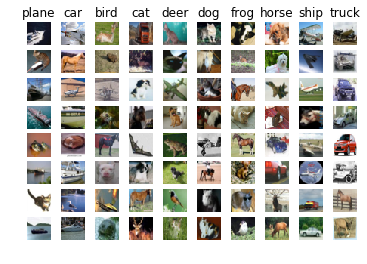

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
print X_train_feats.shape

(49000, 155)


In [12]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
num_iters=1500


for lr in learning_rates:
    for reg in regularization_strengths:
#         results={(lr,reg):(0,0)}
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        loss_hist = net.train(X_train_feats, y_train, X_val_feats,y_val,learning_rate=lr, reg=reg,
                              num_iters=num_iters, verbose=True)

        y_train_pred = svm.predict(X_train_feats)
        train_acc=np.mean(y_train == y_train_pred)
        print 'training accuracy: %f' % (train_acc)
        y_val_pred = svm.predict(X_val_feats)
        val_acc=np.mean(y_val == y_val_pred)
        print 'validation accuracy: %f' % (val_acc)
        results[(lr,reg)]=(train_acc,val_acc)
        print (lr,reg),':',(train_acc,val_acc)
        if val_acc>best_val:
            best_val=val_acc
            best_svm=svm

pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.302585
iteration 200 / 1500: loss 2.302585
iteration 300 / 1500: loss 2.302585
iteration 400 / 1500: loss 2.302585
iteration 500 / 1500: loss 2.302585
iteration 600 / 1500: loss 2.302585
iteration 700 / 1500: loss 2.302585
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: loss 2.302585
iteration 1000 / 1500: loss 2.302585
iteration 1100 / 1500: loss 2.302585
iteration 1200 / 1500: loss 2.302585
iteration 1300 / 1500: loss 2.302585
iteration 1400 / 1500: loss 2.302585
training accuracy: 0.414245
validation accuracy: 0.416000
(1e-07, 0) : (0.41424489795918368, 0.41599999999999998)
iteration 0 / 1500: loss 2.302668
iteration 100 / 1500: loss 2.302667
iteration 200 / 1500: loss 2.302668
iteration 300 / 1500: loss 2.302668
iteration 400 / 1500: loss 2.302668
iteration 500 / 1500: loss 2.302668
iteration 600 / 1500: loss 2.302668
iteration 700 / 1500: loss 2.302667
iteration 800 / 1500: loss 2.302668
iteration 900 / 1500:

iteration 900 / 1500: loss 2.302913
iteration 1000 / 1500: loss 2.302913
iteration 1100 / 1500: loss 2.302913
iteration 1200 / 1500: loss 2.302913
iteration 1300 / 1500: loss 2.302913
iteration 1400 / 1500: loss 2.302913
training accuracy: 0.414245
validation accuracy: 0.416000
(1e-06, 0.8) : (0.41424489795918368, 0.41599999999999998)
iteration 0 / 1500: loss 2.303003
iteration 100 / 1500: loss 2.303002
iteration 200 / 1500: loss 2.303002
iteration 300 / 1500: loss 2.303002
iteration 400 / 1500: loss 2.303002
iteration 500 / 1500: loss 2.303002
iteration 600 / 1500: loss 2.303002
iteration 700 / 1500: loss 2.303002
iteration 800 / 1500: loss 2.303002
iteration 900 / 1500: loss 2.303002
iteration 1000 / 1500: loss 2.303001
iteration 1100 / 1500: loss 2.303001
iteration 1200 / 1500: loss 2.303001
iteration 1300 / 1500: loss 2.303001
iteration 1400 / 1500: loss 2.303001
training accuracy: 0.414245
validation accuracy: 0.416000
(1e-06, 1) : (0.41424489795918368, 0.41599999999999998)
iterat

iteration 100 / 1500: loss 2.336858
iteration 200 / 1500: loss 2.330974
iteration 300 / 1500: loss 2.326249
iteration 400 / 1500: loss 2.322423
iteration 500 / 1500: loss 2.319249
iteration 600 / 1500: loss 2.316716
iteration 700 / 1500: loss 2.314584
iteration 800 / 1500: loss 2.312844
iteration 900 / 1500: loss 2.311396
iteration 1000 / 1500: loss 2.310180
iteration 1100 / 1500: loss 2.309184
iteration 1200 / 1500: loss 2.308331
iteration 1300 / 1500: loss 2.307627
iteration 1400 / 1500: loss 2.307028
training accuracy: 0.414245
validation accuracy: 0.416000
(1e-05, 100.0) : (0.41424489795918368, 0.41599999999999998)
iteration 0 / 1500: loss 2.717478
iteration 100 / 1500: loss 2.364036
iteration 200 / 1500: loss 2.311708
iteration 300 / 1500: loss 2.304013
iteration 400 / 1500: loss 2.302819
iteration 500 / 1500: loss 2.302624
iteration 600 / 1500: loss 2.302592
iteration 700 / 1500: loss 2.302586
iteration 800 / 1500: loss 2.302585
iteration 900 / 1500: loss 2.302585
iteration 1000 

iteration 900 / 1500: loss 2.302669
iteration 1000 / 1500: loss 2.302669
iteration 1100 / 1500: loss 2.302669
iteration 1200 / 1500: loss 2.302668
iteration 1300 / 1500: loss 2.302669
iteration 1400 / 1500: loss 2.302668
training accuracy: 0.414245
validation accuracy: 0.416000
(2e-07, 0.2) : (0.41424489795918368, 0.41599999999999998)
iteration 0 / 1500: loss 2.302791
iteration 100 / 1500: loss 2.302791
iteration 200 / 1500: loss 2.302791
iteration 300 / 1500: loss 2.302791
iteration 400 / 1500: loss 2.302791
iteration 500 / 1500: loss 2.302791
iteration 600 / 1500: loss 2.302791
iteration 700 / 1500: loss 2.302791
iteration 800 / 1500: loss 2.302791
iteration 900 / 1500: loss 2.302791
iteration 1000 / 1500: loss 2.302791
iteration 1100 / 1500: loss 2.302791
iteration 1200 / 1500: loss 2.302791
iteration 1300 / 1500: loss 2.302791
iteration 1400 / 1500: loss 2.302791
training accuracy: 0.414245
validation accuracy: 0.416000
(2e-07, 0.5) : (0.41424489795918368, 0.41599999999999998)
iter

iteration 100 / 1500: loss 2.304649
iteration 200 / 1500: loss 2.304645
iteration 300 / 1500: loss 2.304641
iteration 400 / 1500: loss 2.304637
iteration 500 / 1500: loss 2.304634
iteration 600 / 1500: loss 2.304631
iteration 700 / 1500: loss 2.304628
iteration 800 / 1500: loss 2.304625
iteration 900 / 1500: loss 2.304623
iteration 1000 / 1500: loss 2.304619
iteration 1100 / 1500: loss 2.304618
iteration 1200 / 1500: loss 2.304615
iteration 1300 / 1500: loss 2.304612
iteration 1400 / 1500: loss 2.304611
training accuracy: 0.414245
validation accuracy: 0.416000
(2e-06, 5) : (0.41424489795918368, 0.41599999999999998)
iteration 0 / 1500: loss 2.306732
iteration 100 / 1500: loss 2.306717
iteration 200 / 1500: loss 2.306701
iteration 300 / 1500: loss 2.306687
iteration 400 / 1500: loss 2.306673
iteration 500 / 1500: loss 2.306659
iteration 600 / 1500: loss 2.306646
iteration 700 / 1500: loss 2.306633
iteration 800 / 1500: loss 2.306620
iteration 900 / 1500: loss 2.306609
iteration 1000 / 15

iteration 900 / 1500: loss 2.302584
iteration 1000 / 1500: loss 2.302585
iteration 1100 / 1500: loss 2.302585
iteration 1200 / 1500: loss 2.302586
iteration 1300 / 1500: loss 2.302585
iteration 1400 / 1500: loss 2.302584
training accuracy: 0.414245
validation accuracy: 0.416000
(2e-05, 1000.0) : (0.41424489795918368, 0.41599999999999998)


In [14]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.089


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!